## Get the data from the kaggle dataset using their API
Source: https://www.kaggle.com/datasets/andrewsundberg/college-basketball-dataset/data?select=cbb.csv

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import polars as pl
import matplotlib.pyplot as plt
from matplotlib import ticker

file_path = "cbb.csv"

lf = kagglehub.dataset_load(
  KaggleDatasetAdapter.POLARS,
  "andrewsundberg/college-basketball-dataset",
  file_path,
  # See the documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpolars
)

df = lf.collect()

## Exploratory Analysis
* There is a good amount of information about the dataset and column specifics on the kaggle page where the data is from

In [2]:
df.head()

TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
str,str,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,i64
"""North Carolina""","""ACC""",40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,"""2ND""","""1""",2016
"""Wisconsin""","""B10""",40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,"""2ND""","""1""",2015
"""Michigan""","""B10""",40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,"""2ND""","""3""",2018
"""Texas Tech""","""B12""",38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,"""2ND""","""3""",2019
"""Gonzaga""","""WCC""",39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,"""2ND""","""1""",2017


In [3]:
df.describe()
## there are no nulls
## postseason and seed are strings which we may want to make numbers or binary later on
## the 2025 data is not included yet, we could add that in later if we really wanted to

statistic,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64
"""count""","""3885""","""3885""",3885.0,3885.0,3885.0,3885.0,3885.0,3885.0,3885.0,3885.0,3885.0,3885.0,3885.0,3885.0,3885.0,3885.0,3885.0,3885.0,3885.0,3885.0,3885.0,"""3885""","""3885""",3885.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""",0.0
"""mean""",null,null,30.531532,16.075418,103.339743,103.341519,0.493928,49.935856,50.125946,18.551223,18.483115,29.26731,29.471918,34.384813,34.645766,49.224402,49.38888,34.141133,34.319614,67.712227,-7.639967,null,null,2018.403604
"""std""",null,null,3.809623,6.50657,7.315009,6.490684,0.255374,3.079803,2.855079,2.145057,2.289045,4.201366,3.20732,5.465945,6.33745,3.41638,3.290915,2.713812,2.406306,3.037251,6.826502,null,null,3.583747
"""min""","""Abilene Christian""","""A10""",5.0,0.0,76.6,84.0,0.005,39.2,39.6,11.9,10.2,14.4,18.4,19.6,16.2,37.7,37.7,24.7,26.1,57.2,-25.2,"""2ND""","""1""",2013.0
"""25%""",null,null,29.0,11.0,98.3,98.6,0.2812,47.9,48.2,17.1,16.9,26.5,27.2,30.5,30.1,46.9,47.2,32.3,32.7,65.7,-12.6,null,null,2015.0
"""50%""",null,null,31.0,16.0,103.0,103.5,0.474,49.9,50.1,18.5,18.4,29.3,29.4,34.2,34.0,49.2,49.4,34.1,34.3,67.6,-8.1,null,null,2018.0
"""75%""",null,null,33.0,21.0,108.1,108.0,0.7164,52.0,52.0,19.9,19.9,32.0,31.6,38.0,38.6,51.4,51.7,35.9,35.9,69.7,-3.0,null,null,2022.0
"""max""","""Youngstown St.""","""ind""",40.0,38.0,129.1,124.0,0.9842,61.0,60.1,27.1,28.5,43.6,40.4,58.6,60.7,64.0,61.2,44.1,43.1,83.4,13.1,"""S16""","""NA""",2024.0


## Data transformation:
* For this project, I am going to try to predict the number of postseason wins for each team in hopes of predicting the elusive perfect bracket
* This will require some transformations to the data namely:
    * translating the POSTSEASON column into a POSTSEASON_WINS column which will become our depenedent variable
    * removing all of the data for the teams that did not make the post-season: all of these teams would effectively have 0 post-season wins and would add a lot of data that has little value because we are aiming to differentiate between the top teams that made the tournament when completing a bracket

In [4]:
## Looking at these results, we can figure out which variables we need to translate
print(df.get_column('POSTSEASON').unique().to_list())

## This output shows there is no differentiation for the Round of R68 teams
## Since these games are often ignored in classic 64 team brackets, they will be counted as 0 postseason win teams along with the R64 teams
print(df.get_column('SEED').unique().to_list())

['R68', 'Champions', 'S16', 'R64', 'E8', 'NA', 'F4', 'R32', 'N/A', '2ND']
['12', '14', '15', '1', '8', '5', '6', '3', 'NA', '16', '11', '13', '7', '9', '2', '10', '4', 'N/A']


In [5]:
POSTSEASON_to_WINS = {
    'R68':      0, 
    'R64':      0, 
    'R32':      1, 
    'S16':      2, 
    'E8':       3, 
    'F4':       4, 
    '2ND':      5, 
    'Champions':6, 
}

df_postseason_wins = (df
                      .filter(pl.col('POSTSEASON').is_in(POSTSEASON_to_WINS.keys()))
                      .with_columns(pl.col('POSTSEASON').replace(POSTSEASON_to_WINS).alias('POSTSEASON_WINS').cast(pl.Int32),
                                    pl.col('SEED').cast(pl.Int32))
                )

df_postseason_wins

TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,POSTSEASON_WINS
str,str,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32,i64,i32
"""North Carolina""","""ACC""",40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,"""2ND""",1,2016,5
"""Wisconsin""","""B10""",40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,"""2ND""",1,2015,5
"""Michigan""","""B10""",40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,"""2ND""",3,2018,5
"""Texas Tech""","""B12""",38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,"""2ND""",3,2019,5
"""Gonzaga""","""WCC""",39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,"""2ND""",1,2017,5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Montana St.""","""BSky""",31,17,102.9,105.8,0.4193,53.9,52.3,16.8,18.6,20.7,28.6,30.7,37.0,53.4,54.1,36.4,32.6,68.5,-12.6,"""R68""",16,2024,0
"""Stetson""","""ASun""",31,22,108.3,114.0,0.3559,53.4,52.0,15.8,13.5,27.5,31.2,31.7,25.9,52.5,52.2,36.5,34.5,66.0,-6.8,"""R64""",16,2024,0
"""Howard""","""MEAC""",32,18,104.5,112.9,0.2913,52.0,50.9,21.4,16.7,33.4,30.7,42.2,39.1,49.2,50.8,37.5,34.0,67.7,-12.1,"""R68""",16,2024,0


## EDA for the Postseason Wins dataframe

#### Total number of postseason wins by seed

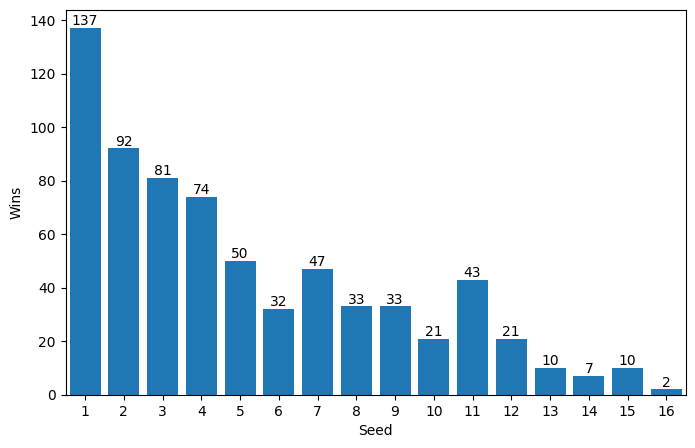

In [6]:
postseason_wins_by_seed = (df_postseason_wins
        .group_by(pl.col('SEED')).agg(pl.col('POSTSEASON_WINS').sum())
        .sort('SEED')
)

## plot
fig, ax = plt.subplots(figsize = (8,5))

plt.bar(postseason_wins_by_seed['SEED'], postseason_wins_by_seed['POSTSEASON_WINS'])

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xlim(postseason_wins_by_seed['SEED'].min()-.5, postseason_wins_by_seed['SEED'].max()+.5)

for bars in ax.containers:
    ax.bar_label(bars)
    
plt.xlabel('Seed'), plt.ylabel('Wins');

A few interesting results intitially:
* 1 seeds are far and away the most winning teams, no surprises there
* There have been some standout 11 seeds with nearly as many wins as 5 seeds!

#### Integrity check: make sure there are the same number of wins per year

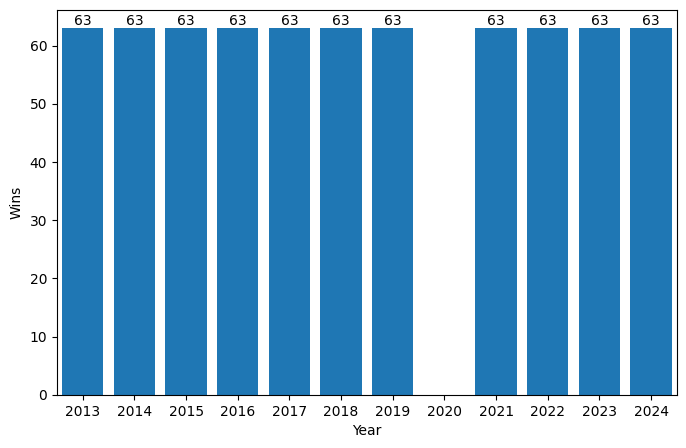

In [7]:
## This should just be a quick check that every year has the same number of total wins in the tourney (63)

wins_by_year = (df_postseason_wins
        .group_by(pl.col('YEAR')).agg(pl.col('POSTSEASON_WINS').sum())
        .sort('YEAR')
)

## plot
fig, ax = plt.subplots(figsize = (8,5))

plt.bar(wins_by_year['YEAR'], wins_by_year['POSTSEASON_WINS'])

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xlim(wins_by_year['YEAR'].min()-.5, wins_by_year['YEAR'].max()+.5)

for bars in ax.containers:
    ax.bar_label(bars)
    
plt.xlabel('Year'), plt.ylabel('Wins');

#### Total wins by team since 2013 (min. 10 wins)

Text(0.5, 0, 'Wins')

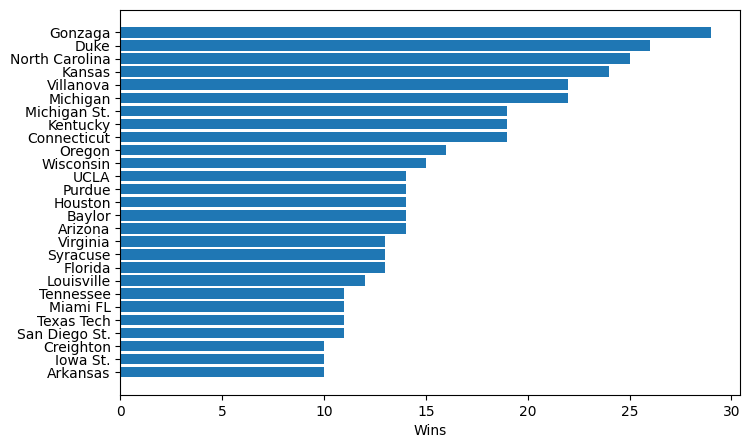

In [8]:
postseason_wins_by_team = (df_postseason_wins
        .group_by(pl.col('TEAM')).agg(pl.col('POSTSEASON_WINS').sum())
        .filter(pl.col('POSTSEASON_WINS') >= 10)
        .sort('POSTSEASON_WINS')
)

## plot
fig, ax = plt.subplots(figsize = (8,5))

plt.barh(postseason_wins_by_team['TEAM'], postseason_wins_by_team['POSTSEASON_WINS'])

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    
plt.xlabel('Wins')

## Save off the data to use for analysis
It will go in the inputs folder with the original data

In [10]:
df_postseason_wins.write_csv('../input_data/cbb_postseason_wins.csv')